### Plant Seeding Classification

#### Calculating Dimensions

Convolution : $\frac{W - K + 2P}{S} + 1$

Trans Convolution : $(I - 1) * S - 2P + K$

In [124]:
# imports
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import glob
import sys
import torch.nn as nn

In [117]:
sys.path.append('/Users/krishuagarwal/Desktop/Programming/python/mlOps/plant-seedings')
from src.model import BaselineCNN

In [125]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes, lr=0.001, epochs=100):
        super().__init__()
        
        # Device configuration
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Model architecture stays the same
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7 * 7 * 512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes),
            nn.LogSoftmax(dim=1) 
        )
        
        self.model = nn.Sequential(self.features, self.classifier)
        
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.criterion = nn.NLLLoss()
        self.epochs = epochs
        
        # Move model to device
        self.to(self.device)
            
        # Information storage
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def forward(self, x):
        return self.model(x)
    
    def train_epoch(self, train_loader):
        self.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            # Move data to device
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self(images)
            loss = self.criterion(outputs, labels)

            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_accuracy)
        
        return epoch_loss, epoch_accuracy
    
    def validate_epoch(self, val_loader):
        self.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_accuracy = correct / total
        self.val_losses.append(epoch_loss)
        self.val_accuracies.append(epoch_accuracy)
        
        return epoch_loss, epoch_accuracy
    
    def train_model(self, train_loader, val_loader, save_dir='models', verbose=True):
        # Create directory for saving models if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        for epoch in range(self.epochs):
            try:
                train_loss, train_accuracy = self.train_epoch(train_loader)
                val_loss, val_accuracy = self.validate_epoch(val_loader)
            
                if verbose:
                    print(f'Epoch {epoch+1}/{self.epochs}, '
                        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

                torch.save(self.model.state_dict(), f'{save_dir}/baseline_cnn_epoch{epoch+1}.pth')
                print(f'Model saved for epoch {epoch+1}')
                
            except Exception as e:
                print(f"Error during training: {e}")
                break

    def predict(self, images):
        """Generate predictions for a batch of images"""
        self.eval()
        with torch.no_grad():
            images = images.to(self.device)
            outputs = self(images)
            _, predicted = torch.max(outputs, 1)
        return predicted

In [132]:
model_weights = '/Users/krishuagarwal/Desktop/Programming/python/mlOps/plant-seedings/models/baseline_cnn_epoch15.pth'
checkpoint = torch.load(model_weights, map_location=torch.device('cpu'))

# Initialize the model
num_classes = 12  # Adjust based on your dataset
model = BaselineCNN(num_classes=num_classes)
model.model.load_state_dict(checkpoint)


classes = [
    'Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 
    'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 
    'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 
    'Sugar beet'
]



Using device: cpu


In [ ]:
def load_image(image_path):
    """Load an image and preprocess it for the model."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image.unsqueeze(0)  # Add batch dimension

def predict_image(image_path):
    """Predict the class of a single image."""
    image = load_image(image_path)
    model.eval()
    with torch.no_grad():
        output = model(image)
    output = torch.exp(output)  
    _, output = torch.max(output, 1) 
    return classes[output.item()]

def plot_images(image_paths, predictions):
    """Plot images with their predicted classes."""
    plt.figure(figsize=(15, 10))
    for i, (image_path, prediction) in enumerate(zip(image_paths, predictions)):
        image = Image.open(image_path)
        plt.subplot(3, 4, i + 1)
        plt.imshow(image)
        plt.title(prediction)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    

In [146]:
base_path = "/Users/krishuagarwal/Desktop/Programming/python/mlOps/plant-seedings/data/test/"
image_path = base_path + "ffc6f8527.png"
predicted_class = predict_image(image_path)
print(f"Predicted class for {image_path}: {predicted_class}")


Predicted class for /Users/krishuagarwal/Desktop/Programming/python/mlOps/plant-seedings/data/test/ffc6f8527.png: Black-grass


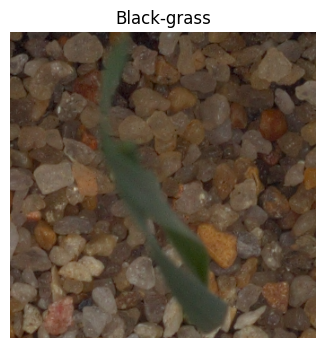

In [147]:
plot_images([image_path], [predicted_class])

All in all we expect the model to perform with accuracy of around 85%, it would be nice if it performs better.